In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import attila_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## DE genes in single cells

First, let's import the results by [Mathys et al 2019, Nature](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6865822/) that defined DE genes in 6 cell types!

In [2]:
#fpath = '../../resources/AD-single-cell/41586_2019_1195_MOESM4_ESM.xlsx'
def read_DEsc(celltype='Mic', fpath='../../resources/AD-single-cell/41586_2019_1195_MOESM4_ESM.xlsx'):
    usecols = [11, 16, 17, 19]
    names = ['Gene', 'MixedModel.z', 'MixedModel.p', 'DEGs.Ind.Mix.models']
    df = pd.read_excel(fpath, sheet_name=celltype, skiprows=[0], usecols=usecols, index_col=0, names=names).dropna()
    df = df.astype({'DEGs.Ind.Mix.models': bool})
    return(df)

DEsc = {celltype: read_DEsc(celltype) for celltype in ['Ex', 'In', 'Ast', 'Oli', 'Opc', 'Mic']}

Write gene sets to files

In [3]:
for celltype in DEsc.keys():
    fpath = '../../results/2022-01-31-single-cell-de-genes/' + 'single-cell-' + celltype + '-de'
    l = DEsc[celltype].index[DEsc[celltype]['DEGs.Ind.Mix.models']].to_list()
    l.sort()
    l = [x + '\n' for x in l]
    with open(fpath, 'w') as f:
        f.writelines(l)

The number of DE genes varies widely across cell types while the number of all genes investigated varies much less.

In [4]:
DEsc_counts = pd.concat([
    pd.DataFrame({k: DEsc[k]['DEGs.Ind.Mix.models'].sum() for k in DEsc.keys()}, index=['DE genes']),
    pd.DataFrame({k: len(DEsc[k]) for k in DEsc.keys()}, index=['all genes'])
], axis=0)
DEsc_counts

,Ex,In,Ast,Oli,Opc,Mic
DE genes,1151,207,51,96,18,10
all genes,13298,12380,11334,9244,11588,8728


The fraction of DE genes spans nearly two orders of magnitude, from $\approx 0.1\%$ to $\approx 9\%$.

In [5]:
DEsc_counts.loc['DE genes'] / DEsc_counts.loc['all genes']

Ex     0.086554
In     0.016721
Ast    0.004500
Oli    0.010385
Opc    0.001553
Mic    0.001146
dtype: float64

['named-figure/count-DE-genes.png', 'named-figure/count-DE-genes.pdf']

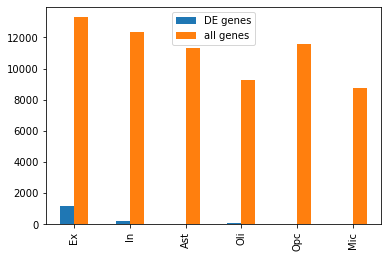

In [6]:
fig, ax = plt.subplots()
DEsc_counts.transpose().plot(kind='bar', ax=ax)
attila_utils.savefig(fig, 'count-DE-genes')

In [7]:
def read_DEip(celltype='Neuron', dirpath='../../results/2021-12-08-apoe-de-genes-tunahan/'):
    fpath = dirpath + celltype + '-apoe-de'
    with open(fpath, 'r') as f:
        genes = f.readlines()
    genes = [s.strip() for s in genes]
    return(genes)

DEip = {celltype: read_DEip(celltype) for celltype in ['Neuron', 'Astrocyte', 'Microglia-like']}

## Comparison to DE genes in IPSC

Here we compare DE gene sets discovered the single-cell study to those discovered by [Lin et al 2018, Neuron](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6023751/).  This means $6 \times 3$ comparisons since there are 6 cell types in [Mathys et al 2019, Nature](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6865822/) and 3 cell types in [Lin et al 2018, Neuron](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6023751/).

In [8]:
def sc_vs_ip(celltype_sc='Ex'):
    df = DEsc[celltype_sc]
    for celltype_ip in ['Neuron', 'Astrocyte', 'Microglia-like']:
        df['DE in ipsc ' + celltype_ip] = df.index.isin(DEip[celltype_ip])
    return(df)

DEsc = {celltype: sc_vs_ip(celltype) for celltype in DEsc.keys()}

The `sc_vs_ip_plot` is a generic plotting function that produces a $6 \times 3$ grid, whose cells are comparisons of DE gene sets from the two studies.

In [9]:
def sc_vs_ip_plot(fun, ylabel='abs Z-score', sharey=False):
    fig, ax = plt.subplots(len(DEsc.keys()), 3, sharey=sharey, sharex=False, figsize=(9, 18))
    for celltype_sc, row in zip(DEsc.keys(), np.arange(len(DEsc.keys()))):
        for celltype_ip, axi in zip(['Neuron', 'Astrocyte', 'Microglia-like'], ax[row, :]):
            if row == 0:
                axi.set_title('DE in ipsc ' + celltype_ip + '?')
            if celltype_ip == 'Neuron':
                axi.set_ylabel(celltype_sc + ': ' + ylabel)
            axi = fun(axi, celltype_sc=celltype_sc, celltype_ip=celltype_ip)
    return((fig, ax))

The function `my_boxplot` compares the Z-score (its absolute value) from the mixed model fit by [Mathys et al 2019, Nature](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6865822/) for DE genes vs. not DE genes in [Lin et al 2018, Neuron](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6023751/).

We see no clear difference in any of the $6 \times 3 = 18$ comparisons, which suggests that the gene sets discovered by [Mathys et al 2019, Nature](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6865822/) share no information with the [Lin et al 2018, Neuron](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6023751/) study.

['named-figure/boxplot-single-cell_vs_ipsc.png',
 'named-figure/boxplot-single-cell_vs_ipsc.pdf']

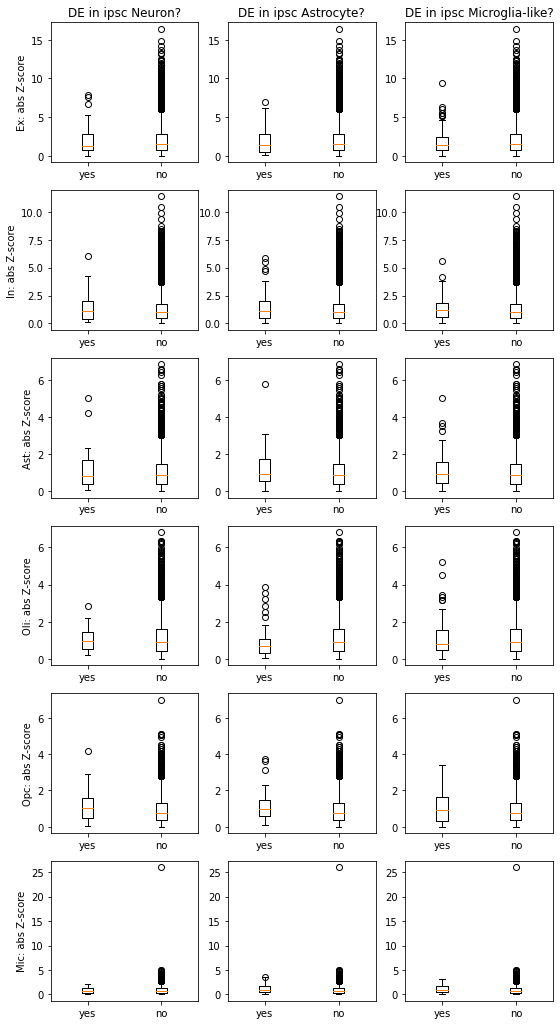

In [10]:
def my_boxplot(ax, celltype_sc='Ex', celltype_ip='Neuron', zscore=True):
    if zscore:
        supported = DEsc[celltype_sc].loc[DEsc[celltype_sc]['DE in ipsc ' + celltype_ip], 'MixedModel.z'].abs()
        not_supported = DEsc[celltype_sc].loc[~ DEsc[celltype_sc]['DE in ipsc ' + celltype_ip], 'MixedModel.z'].abs()
    else:
        supported = DEsc[celltype_sc].loc[DEsc[celltype_sc]['DE in ipsc ' + celltype_ip], 'MixedModel.p']
        not_supported = DEsc[celltype_sc].loc[~ DEsc[celltype_sc]['DE in ipsc ' + celltype_ip], 'MixedModel.p']
    ax.boxplot([supported, not_supported])
    ax.set_xticklabels(['yes', 'no'])
    if not zscore:
        ax.set_yscale('log')
    return(ax)

fig, ax = sc_vs_ip_plot(fun=my_boxplot, ylabel='abs Z-score')
attila_utils.savefig(fig, 'boxplot-single-cell_vs_ipsc')

`my_fracplot` presents the fraction of DE genes in all genes investigated in a given cell type by [Mathys et al 2019, Nature](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6865822/).  We compare that fraction in DE genes by [Lin et al 2018, Neuron](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6023751/) to the corresponding fraction in non-DE genes.  The same conclusion can be drawn as above.

['named-figure/fraction-single-cell_vs_ipsc.png',
 'named-figure/fraction-single-cell_vs_ipsc.pdf']

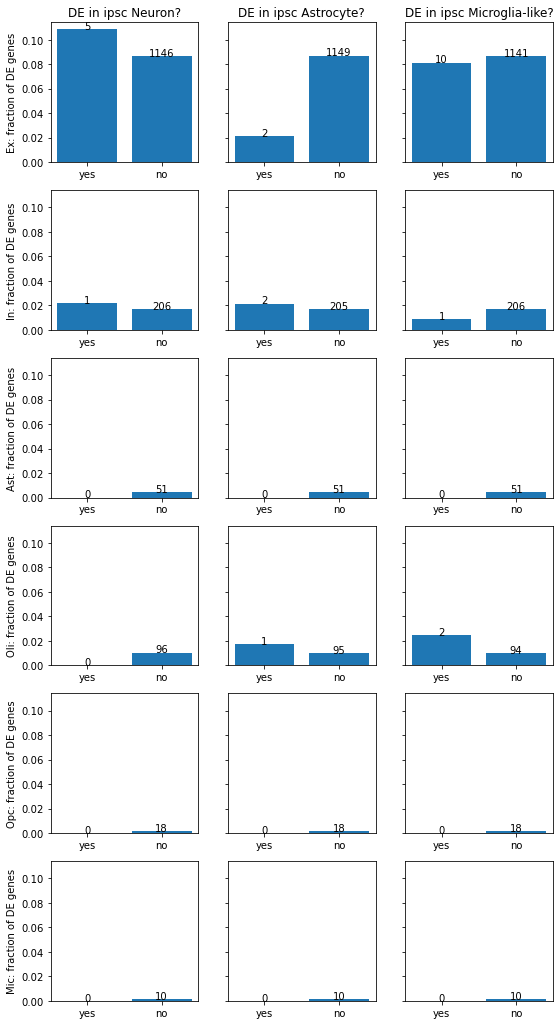

In [11]:
def my_fracplot(ax, celltype_sc='Ex', celltype_ip='Neuron'):
    DE_in_sc = DEsc[celltype_sc]['DEGs.Ind.Mix.models']
    DE_in_ip = DEsc[celltype_sc]['DE in ipsc ' + celltype_ip]
    # fraction of DE genes in single-cells given their DE status in ipsc's
    fractions = pd.crosstab(index=DE_in_sc, columns=DE_in_ip, normalize='columns').loc[True]
    counts = pd.crosstab(index=DE_in_sc, columns=DE_in_ip).loc[True]
    # reverse index
    fractions = fractions.iloc[::-1]
    counts = counts.iloc[::-1]
    ax.bar(height=fractions, x=[0, 1])
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['yes', 'no'])
    ax.text(0, fractions.loc[True], counts.loc[True], horizontalalignment='center')
    ax.text(1, fractions.loc[False], counts.loc[False], horizontalalignment='center')
    return(fractions)

fig, ax = sc_vs_ip_plot(fun=my_fracplot, ylabel='fraction of DE genes', sharey=True)
attila_utils.savefig(fig, 'fraction-single-cell_vs_ipsc')

In [12]:
%connect_info

{
  "shell_port": 55169,
  "iopub_port": 55170,
  "stdin_port": 55171,
  "control_port": 55173,
  "hb_port": 55172,
  "ip": "127.0.0.1",
  "key": "006612dc-c5adcd6c43ab34cf83f1a504",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-81598780-9d9b-4740-ae94-ee15d5a459cb.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
